In [ ]:
!pip install split-folders
!pip install torch-summary

In [ ]:
#https://www.kaggle.com/datasets/gunjansanjaykadam/brainn-tumorr/data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

Load dataset

In [ ]:
labels_df = pd.read_csv('/kaggle/input/brainn-tumorr/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [ ]:
os.listdir('/kaggle/input/brainn-tumorr/Brain Tumor Data Set/Brain Tumor Data Set')


['Brain Tumor', 'Healthy']

In [ ]:
labels_df.shape

(4600, 6)

data splitting

In [ ]:
data_dir = '/kaggle/input/brainn-tumorr/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))

data_dir = '/kaggle/working/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:29, 157.14 files/s]


image augumentation

In [ ]:

transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [ ]:

train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

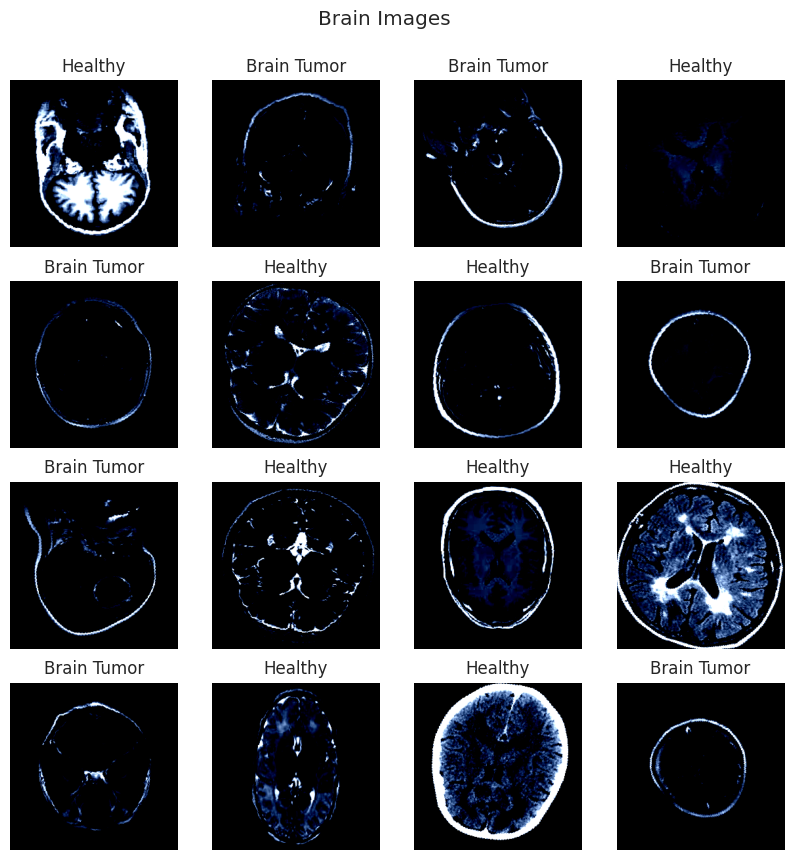

In [ ]:
import torch

# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

creating loaders

In [ ]:

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

In [ ]:

for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



defining CNN_model

In [ ]:
def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [ ]:
class CNN_TUMOR(nn.Module):

    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)

        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):

        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [ ]:
params_model={
        "shape_in": (3,256,256),
        "initial_filters": 8,
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

cnn_model = CNN_TUMOR(params_model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [ ]:
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

defining loss function and optimizer

In [ ]:
loss_func = nn.NLLLoss(reduction="sum")

In [ ]:
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

Training

In [ ]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    metric_b=pred.eq(target.view_as(pred)).sum().item()

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb)
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        run_loss+=loss_b

        if metric_b is not None:
            t_metric+=metric_b

    loss=run_loss/float(len_data)
    metric=t_metric/float(len_data)

    return loss, metric

In [ ]:
def Train_Val(model, params,verbose=False):

    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss=float('inf')



    for epoch in tqdm(range(epochs)):


        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)




        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [ ]:
params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

Evaluation metric

<Axes: >

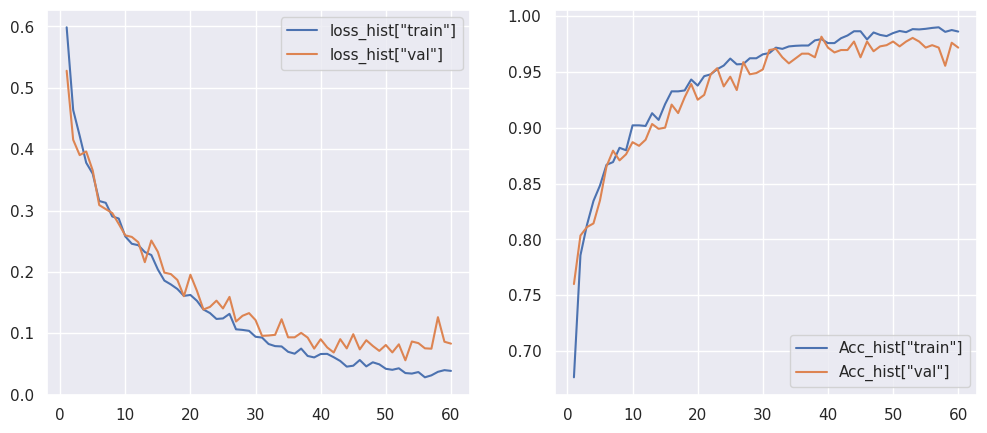

In [ ]:
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

confusion matrix

In [ ]:
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred


y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       503
         1.0       0.98      0.97      0.98       418

    accuracy                           0.98       921
   macro avg       0.98      0.98      0.98       921
weighted avg       0.98      0.98      0.98       921
 




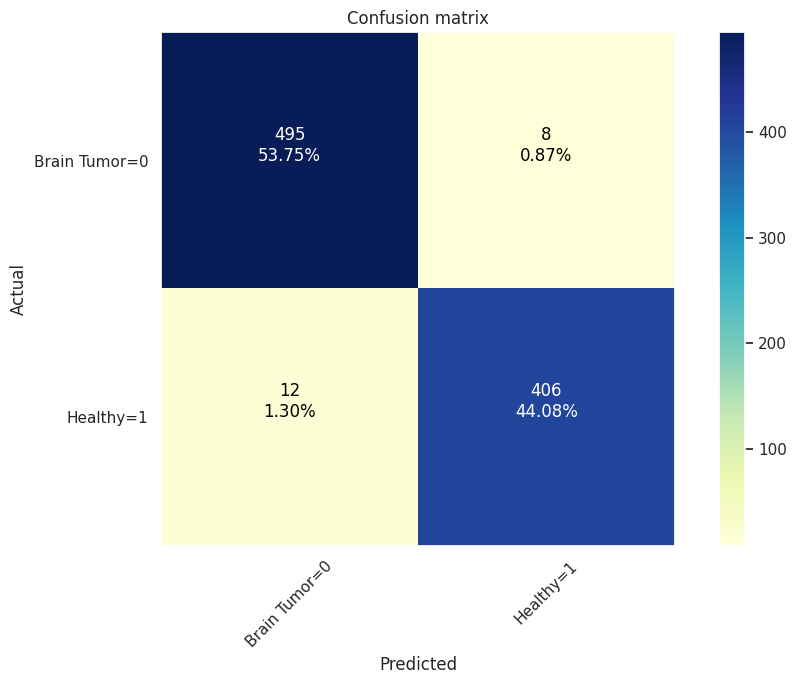

In [ ]:
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

Prognosis using dummy data

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class TumorPrognosisDataset(Dataset):
    def __init__(self, image_paths, labels_tumor, labels_life_expectancy, labels_recovery, transform=None):
        self.image_paths = image_paths
        self.labels_tumor = labels_tumor
        self.labels_life_expectancy = labels_life_expectancy
        self.labels_recovery = labels_recovery
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)

        label_tumor = self.labels_tumor[idx]
        label_life_expectancy = self.labels_life_expectancy[idx]
        label_recovery = self.labels_recovery[idx]

        return image, label_tumor, label_life_expectancy, label_recovery

# Sample dataset setup
image_paths = ["/kaggle/input/brainn-tumorr/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg", "/kaggle/input/brainn-tumorr/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (100).jpg"]
labels_tumor = [1, 0]  # Example labels: 1 for tumor, 0 for no tumor
labels_life_expectancy = [5, 20]  # Example life expectancy in years
labels_recovery = [0.5, 1.0]  # Example recovery likelihood (0 to 1)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = TumorPrognosisDataset(image_paths, labels_tumor, labels_life_expectancy, labels_recovery, transform=transform)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TumorPrognosisCNN(nn.Module):
    def __init__(self):
        super(TumorPrognosisCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 30 * 30, 256)
        self.fc2_tumor = nn.Linear(256, 2)

        # Prognosis outputs
        self.fc2_life_expectancy = nn.Linear(256, 1)
        self.fc2_recovery = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 30 * 30)

        x = F.relu(self.fc1(x))

        tumor_pred = self.fc2_tumor(x)
        life_expectancy = self.fc2_life_expectancy(x)
        recovery_likelihood = torch.sigmoid(self.fc2_recovery(x))

        return tumor_pred, life_expectancy, recovery_likelihood


In [ ]:
model = TumorPrognosisCNN().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

def estimate_prognosis(tumor_present, patient_age=65, tumor_severity=3):
    base_life_expectancy = 80 - patient_age
    if tumor_present:
        life_expectancy = base_life_expectancy - (tumor_severity * 5)
        recovery_likelihood = max(0, 1 - (tumor_severity * 0.15))
    else:
        life_expectancy = base_life_expectancy
        recovery_likelihood = 1.0

    life_expectancy = max(2, life_expectancy)
    return life_expectancy, recovery_likelihood


model.eval()

for images, labels_tumor, labels_life_expectancy, labels_recovery in train_loader:
    images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    with torch.no_grad():
        tumor_pred, life_pred, recovery_pred = model(images)

    _, tumor_prediction = torch.max(tumor_pred, 1)
    tumor_present = tumor_prediction.item() == 1

    # Example values for prognosis
    patient_age = 65
    tumor_severity = 3

    life_expectancy, recovery_likelihood = estimate_prognosis(tumor_present, patient_age, tumor_severity)

    print(f"Tumor Present: {tumor_present}")
    print(f"Estimated Life Expectancy: {life_expectancy} years")
    print(f"Recovery Likelihood: {recovery_likelihood * 100:.2f}%")


Tumor Present: True
Estimated Life Expectancy: 2 years
Recovery Likelihood: 55.00%
Tumor Present: True
Estimated Life Expectancy: 2 years
Recovery Likelihood: 55.00%
